In [1]:
%matplotlib inline

In [3]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [4]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mock.Lbox = 500.


In [5]:
from cosmodc2.sdss_colors import mock_magr

mock['restframe_extincted_sdss_abs_magr'] = mock_magr(
            mock['upid'], mock['obs_sm'], mock['sfr_percentile'], 
            mock['host_halo_mvir'], sdss['sm'], sdss['sfr_percentile_fixed_sm'], 
            sdss['restframe_extincted_sdss_abs_magr'], sdss['z'])


In [6]:
from cosmodc2.sdss_colors import gr_ri_monte_carlo

magr = mock['restframe_extincted_sdss_abs_magr'] 
percentile = mock['sfr_percentile']
redshift = np.zeros_like(magr)

gr, ri, is_red_ri, is_red_gr = gr_ri_monte_carlo(
    magr, percentile, redshift, local_random_scale=0.1)

mock['restframe_extincted_sdss_gr'] = gr
mock['restframe_extincted_sdss_ri'] = ri
mock['is_red_gr'] = is_red_gr
mock['is_red_ri'] = is_red_ri


from cosmodc2.sdss_colors import remap_cluster_bcg_gr_ri_color
_result = remap_cluster_bcg_gr_ri_color(
        mock['upid'], mock['host_halo_mvir'], 
        np.copy(mock['restframe_extincted_sdss_gr']), 
        np.copy(mock['restframe_extincted_sdss_ri']), 
        mock['is_red_gr'], mock['is_red_ri'])
gr_remapped, ri_remapped, is_red_gr_remapped, is_red_ri_remapped = _result

mock['_gr_no_remap'] = np.copy(mock['restframe_extincted_sdss_gr'])
mock['_ri_no_remap'] = np.copy(mock['restframe_extincted_sdss_ri'])
mock['restframe_extincted_sdss_gr'] = gr_remapped
mock['restframe_extincted_sdss_ri'] = ri_remapped
mock['_is_red_ri_no_remap'] = np.copy(is_red_ri)
mock['_is_red_gr_no_remap'] = np.copy(is_red_gr)
mock['is_red_gr'] = is_red_gr_remapped
mock['is_red_ri'] = is_red_ri_remapped


In [7]:
from cosmodc2.sdss_colors.fix_cluster_lf import cluster_bcg_red_sequence_gr_ri
from halotools.empirical_models import conditional_abunmatch


def prob_remap_cluster_satellite(upid, mstar, host_halo_mvir,
            x1=(9, 9.75, 10.25, 11), y1=(1., 1., 1., 1.),
            x2=(13.5, 14, 14.5), y2=(0.0, 0.5, 0.75)):
    """
    """
    ngals = len(mstar)
    satmask = upid != -1
    mstar_prob = np.interp(np.log10(mstar), x1, y1)
    mhost_prob = np.interp(np.log10(host_halo_mvir), x2, y2)
    mstar_mask = np.random.rand(ngals) < mstar_prob
    mhost_mask = np.random.rand(ngals) < mhost_prob
    remapping_mask = mstar_mask & mhost_mask & satmask
    return remapping_mask


def remap_satellites(mstar, gr, ri, 
                     gr_red_sequence_median, ri_red_sequence_median, 
                     gr_red_sequence_scatter, ri_red_sequence_scatter,
                    nwin=301):
    """
    """
    num_to_remap = len(mstar)
    bcg_red_sequence_gr, bcg_red_sequence_ri = cluster_bcg_red_sequence_gr_ri(
        num_to_remap, gr_red_sequence_median,
        ri_red_sequence_median, gr_red_sequence_scatter)

    input_gr = gr
    desired_gr = bcg_red_sequence_gr
    output_gr = conditional_abunmatch(
        mstar, input_gr, mstar, desired_gr, nwin)

    desired_ri = bcg_red_sequence_ri
    noisy_input_gr = np.random.normal(loc=output_gr, scale=0.1)
    output_ri = conditional_abunmatch(
        mstar, noisy_input_gr, mstar, desired_ri, nwin)
    return output_gr, output_ri

In [8]:
from cosmodc2.sdss_colors.analytical_colors import red_sequence_peak_gr, red_sequence_peak_ri
from cosmodc2.sdss_colors.analytical_colors import red_sequence_width_gr, red_sequence_width_ri

remapping_mask = prob_remap_cluster_satellite(mock['upid'], mock['obs_sm'],
                        mock['host_halo_mvir'])

gr_peak = red_sequence_peak_gr(mock['restframe_extincted_sdss_abs_magr'][remapping_mask])
ri_peak = red_sequence_peak_ri(mock['restframe_extincted_sdss_abs_magr'][remapping_mask])
gr_scatter = 0.04
ri_scatter = 0.03

mstar = mock['obs_sm'][remapping_mask]
gr = mock['restframe_extincted_sdss_gr'][remapping_mask]
ri = mock['restframe_extincted_sdss_ri'][remapping_mask]
new_gr, new_ri = remap_satellites(mstar, gr, ri, gr_peak, ri_peak, gr_scatter, ri_scatter)

mock['restframe_extincted_sdss_gr'][remapping_mask] = new_gr
mock['restframe_extincted_sdss_ri'][remapping_mask] = new_ri


In [11]:
'sfr_percentile' in mock.keys()

True

In [16]:
from cosmodc2.black_hole_modeling import bh_mass_from_bulge_mass
mock['bt'] = np.random.rand(len(mock))
mock['bh_mass'] = bh_mass_from_bulge_mass(mock['obs_sm']*mock['bt'])

In [57]:
from cosmodc2.black_hole_modeling import monte_carlo_specific_bh_acc_rate
mock['log_eddington_ratio'] = monte_carlo_specific_bh_acc_rate(0., mock['sfr_percentile'])
mock['bh_acc_rate'] = mock['bh_mass']*(10**mock['log_eddington_ratio'])

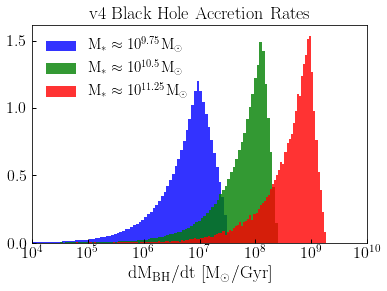

In [81]:
sm_mask = (mock['obs_sm'] > 10**9.5) & (mock['obs_sm'] < 10**10)
sm_mask2 = (mock['obs_sm'] > 10**10.5) & (mock['obs_sm'] < 10**10.75)
sm_mask3 = (mock['obs_sm'] > 10**11.25) & (mock['obs_sm'] < 10**11.5)


fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(mock['bh_acc_rate'][sm_mask]), bins=150, normed=True,
          alpha=0.8, color='blue', label=r'${\rm M_{\ast}\approx 10^{9.75}M_{\odot}}$')

__=ax.hist(np.log10(mock['bh_acc_rate'][sm_mask2]), bins=150, normed=True,
          alpha=0.8, color='green', label=r'${\rm M_{\ast}\approx 10^{10.5}M_{\odot}}$')

__=ax.hist(np.log10(mock['bh_acc_rate'][sm_mask3]), bins=150, normed=True,
          alpha=0.8, color='red', label=r'${\rm M_{\ast}\approx 10^{11.25}M_{\odot}}$')

xtick_labels = (r"$10^{4}$", r"$10^{5}$", r"$10^{6}$", 
                r"$10^{7}$", r"$10^{8}$", r"$10^{9}$", r"$10^{10}$")

ax.set_xticklabels(xtick_labels)

xlabel = ax.set_xlabel(r'${{\rm dM_{BH}/dt}\ [{\rm M_{\odot}/Gyr}]}$')
title = ax.set_title(r'${\rm v4\ Black\ Hole\ Accretion\ Rates}$')
xlim = ax.set_xlim(4, 10)
legend = ax.legend()

figname = 'black_hole_accretion_rates.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')